In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
# export
import os
import torch as T
import numpy as np
import math
import pandas as pd
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

In [3]:
%matplotlib inline

In [4]:
def draw_outline(o, lw, foreground='black'):
    import matplotlib.patheffects as patheffects
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground=foreground), patheffects.Normal()])

In [5]:
# export
class imagenetStats:
    def __init__(self, UseInception=True):
        self.UseInception=UseInception
        self.IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
        self.IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
        self.IMAGENET_INCEPTION_MEAN = (0.5, 0.5, 0.5)
        self.IMAGENET_INCEPTION_STD = (0.5, 0.5, 0.5)
    def getMean(self):
        if self.UseInception: return self.IMAGENET_INCEPTION_MEAN[0]
        
    def getSTD(self):
        if self.UseInception: return self.IMAGENET_INCEPTION_STD[0]
        

In [6]:
transform=imagenetStats(UseInception=True)

transform.getMean(),transform.getSTD()

(0.5, 0.5)

In [7]:
# export
def set_seed(x): 
    #random.seed(x)
    np.random.seed(x)
    T.manual_seed(x)
    T.backends.cudnn.deterministic = True
    T.backends.cudnn.benchmark = False
    if T.cuda.is_available(): 
        T.cuda.manual_seed_all(x)

In [8]:
set_seed(42)

In [21]:
# export 
def byte2np_RGB(response, Save=False, path='data', filename='Test', ClrFirst=True):
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8)
    # reshape array to 4 channel image array H X W X 4
    if ClrFirst: img_rgb = img1d.reshape(3, response.height, response.width)
    else: img_rgb = img1d.reshape(response.height, response.width, 3)
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, img_rgb)
    return img_rgb

In [22]:
# export 
def byte2np_Depth(response, Save=False, path='data', filename='Test', Normalize=True):
    img1d = np.array(response.image_data_float, dtype=np.float)
    if Normalize:
        img1d = img1d * 3.5 + 30
        img1d[img1d > 255] = 255
        img1d=img1d/255
    depth = np.reshape(img1d, (response.height, response.width))
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, depth)
    return depth

In [23]:
# export
def ChangeColor(img, clr_og, clr_new):
    r1, g1, b1 = clr_og # Original value
    r2, g2, b2 = clr_new # Value that we want to replace it with

    blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]
    mask = (red == r1) & (green == g1) & (blue == b1)
    img[:,:,:3][mask] = [b2, g2, r2]
    return img

In [97]:
# export
def byte2np_Seg(response, Save=False, path='data', filename=f'Test', JustRoad=False):
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8)
    img = img1d.reshape(response.height, response.width, 3)
    # Change sky and road color
    road = [177, 172, 224] # RGB road 
    sky = [128, 219, 130] # RGB Sky 

    img=ChangeColor(img, clr_og=road, clr_new=[255,255,255])
    img=ChangeColor(img, clr_og=sky, clr_new=[0,0,0])
    # convert to greyscale
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
    if JustRoad: img=np.ma.masked_where(img == 1, img).mask.astype(int)
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, img)
    return img

In [25]:
#print(self.df_gps.df.head())
#img_depth=util.byte2np_Depth(self.responses[0], Save=False, path='data', filename='Front_center_DepthPlanarS')
#img_rgb=util.byte2np_RGB(self.responses[1], Save=True, path='data', filename='Front_center_RGBS')
#img_seg=util.byte2np_Seg(self.responses[2], Save=False, path='data', filename=f'Front_center_Seg_{self.episode}_{int(self.deltaTime*1000)}')
#img_gps=self.df_gps.GPS2image(Save=False, path='data', filename='GPS')

In [26]:
sz=(224,224)

In [27]:
#depth=np.load('data/Front_center_DepthPlanarS.npy')
#plt.imshow(depth, interpolation='nearest', cmap='gray')
#plt.show()

In [28]:
#depth=np.load('data/Bottom_center_DepthPlanarS.npy')

In [29]:
#plt.imshow(depth, interpolation='nearest', cmap='gray')
#plt.show()

In [30]:
# export
def Distance2Grnd(img, sz, rng=10):
    x,y=sz
    x=int(x/2)
    y=int(y/2)
    return np.mean(img[x-rng:x+rng,y-rng:y+rng])

In [31]:
#Distance2Grnd(depth, sz, rng=10)

In [32]:
def plot_3hgtwdth(img, ClrChng=True):
    img=img.reshape(img.shape[1], img.shape[2],3)
    if ClrChng: img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, interpolation='nearest')
    plt.show()

In [33]:
#img=np.load('data/Front_center_RGBS.npy')
#plot_3hgtwdth(img)

In [34]:
#img=np.load('data/GPS.npy')
#plot_3hgtwdth(img, ClrChng=False)

In [35]:
#img=np.load('data/Front_center_SegS.npy')
#img_=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img_, interpolation='nearest')
#plt.show()

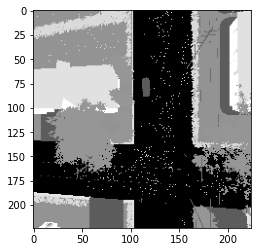

In [36]:
fn = [o.name for o in os.scandir('data') if o.name.find('Seg_')!=-1][0]
img=np.load(f'data/{fn}')
plt.imshow(img, cmap='Greys')
plt.show()

In [37]:
sz=(224,224)

In [38]:
# export
def isRoadBelow(img, sz, rng=10):
    x,y=sz
    x=int(x/2)
    y=int(y/2)
    med=np.median(img[x-rng:x+rng,y-rng:y+rng])
    if med >0.98: return True
    else: return False

In [39]:
isRoadBelow(img, sz, rng=10)

True

In [40]:
df_mesh=pd.read_csv('data/meshes.csv', index_col=0)
#df_mesh['0'].unique()

In [41]:
#df_mesh['0'].unique()

In [12]:
# export
def Value2Color(val, vmin=0, vmax=1, palette='YlOrRd', zerocolor='#e3e3e3'):    
    """Input value from vmin to vmax returns hex color based on value and palette"""
    import matplotlib as mpl
    import matplotlib.cm as cm
    try:
        if np.isnan(val):
            clr='#e3e3e3' # grey
        elif val==0: clr=zerocolor# green if zero
        else:
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            cmap = cm.get_cmap(palette)   
            m = cm.ScalarMappable(norm=norm, cmap=cmap)
            rgba=m.to_rgba(val)
            clr=mpl.colors.to_hex(rgba)
    except: clr='#e3e3e3' # grey
    return clr

In [13]:
# export
def plotcolorline(x, y, z, cmap='YlOrRd', norm=plt.Normalize(0.0, 1.0), 
              linewidth=3, alpha=1.0):
    #breaks lines into segments and plots segment color as z value in colormap
    import matplotlib.collections as mcoll
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)

    return lc

In [14]:
#function to convert x, y , z vector to gps coordinates needed
# c++
_='''static GeoPoint nedToGeodetic(const Vector3r& v, const HomeGeoPoint& home_geo_point)
        {
            double x_rad = v.x() / EARTH_RADIUS;
            double y_rad = v.y() / EARTH_RADIUS;
            double c = sqrt(x_rad * x_rad + y_rad * y_rad);
            double sin_c = sin(c), cos_c = cos(c);
            double lat_rad, lon_rad;
            if (!Utils::isApproximatelyZero(c)) { //avoids large changes?
                lat_rad = asin(cos_c * home_geo_point.sin_lat + (x_rad * sin_c * home_geo_point.cos_lat) / c);
                lon_rad = (home_geo_point.lon_rad +
                           atan2(y_rad * sin_c, c * home_geo_point.cos_lat * cos_c - x_rad * home_geo_point.sin_lat * sin_c));

                return GeoPoint(Utils::radiansToDegrees(lat_rad), Utils::radiansToDegrees(lon_rad), home_geo_point.home_geo_point.altitude - v.z());
            }
            else
                return GeoPoint(home_geo_point.home_geo_point.latitude, home_geo_point.home_geo_point.longitude, home_geo_point.home_geo_point.altitude - v.z());
        }'''

# this is the print statement from self.client.getGpsData():
_='''<GpsData> {   'gnss': <GnssReport> {   'eph': 0.3000044822692871,
    'epv': 0.40000447630882263,
    'fix_type': 3,
    'geo_point': <GeoPoint> {   'altitude': 132.32289123535156,
    'latitude': 47.6416150728889,
    'longitude': -122.14040436968116},
    'time_utc': 1645971445395087,
    'velocity': <Vector3r> {   'x_val': -0.24463589489459991,
    'y_val': 0.05023214593529701,
    'z_val': -0.6591682434082031}},
    'is_valid': True,
    'time_stamp': 1645971445395087360} <Vector3r> {   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355}
'''

In [24]:
# export
class GPShistory:
    def __init__(self, position, velocity, reward, time_stamp, vehicle_name, image_size, maxspeed, info=''):
        self.columns=['x_position', 'y_position', 'z_position',
                     'x_velocity', 'y_velocity', 'z_velocity', 
                     'Reward', 'time_stamp', 'vehicle_name', 'info']
        self.sz=image_size
        self.vehicle_name=vehicle_name
        self.maxspeed= maxspeed
        self.df=pd.DataFrame([[position.x_val, position.y_val, position.z_val,
                               velocity.x_val, velocity.y_val, velocity.z_val,
                              reward, time_stamp,vehicle_name, info]], columns=self.columns)
        
    def appendGPShistory(self, position, velocity, reward, time_stamp, vehicle_name, info):
        self.df.loc[len(self.df)]= [position.x_val, position.y_val, position.z_val,
                                    velocity.x_val, velocity.y_val, velocity.z_val,
                                    reward, time_stamp,vehicle_name, info]
        
    def saveGPS2csv(self, filename):
        self.df.to_csv(filename, index=False)
        
    def loadGPScsv(self, filename):
        self.df=pd.read_csv(filename)
        
    def getDataframe(self): return self.df
        
    def GPS2image(self, x_cntr, y_cntr, df_nofly=None):
        df=self.df.copy()
        maxspeed=self.maxspeed
        vehicle_name=self.vehicle_name
        sz=self.sz
        rad=100 # meters                
        # ensures the current vehicle is plotted last
        vehicle_lst=list(df[df['vehicle_name']!=vehicle_name]['vehicle_name'].dropna().unique())+[vehicle_name]
        
        #################################### Plotting #########################################################
        fig, ax = plt.subplots(figsize=(5,5))
        ax=plt.gca(); ax.set_axis_off()
        ax.add_patch(patches.Rectangle((x_cntr-rad,y_cntr-rad+1), width=rad*2-1, height=rad*2-1, ec='k', facecolor='#b3b3b3'))
        ax.add_patch(plt.Circle((x_cntr,y_cntr), rad, ec='k', facecolor='white'))
        plt.xlim(x_cntr-rad,x_cntr+rad); plt.ylim(y_cntr-rad,y_cntr+rad) 
        if df_nofly is not None: # plot the no fly zone
            for idx in df_nofly.index:
                ax.add_patch(plt.Circle((df_nofly.loc[idx,'x'], df_nofly.loc[idx,'y']), df_nofly.loc[idx,'radius'],
                                    hatch='xxx',facecolor='grey'))

        # Plot reward and history of drones
        for v_name in vehicle_lst:
            frame=df[df['vehicle_name']==v_name].copy()   
            # set the most recent position to the center of plot and shows 100 meters in all directions                  
            lc = plotcolorline(frame['x_position'], frame['y_position'],frame['Reward'],
                               cmap='Greys_r', norm=plt.Normalize(-100, 20), linewidth=4,alpha=1.0)           

        # ensure current locations are on top
        for v_name in vehicle_lst:
            frame=df[df['vehicle_name']==v_name].copy()
            if v_name==vehicle_name:
                #honey I'm home
                plt.plot(frame.loc[frame.index[0],'x_position'], frame.loc[frame.index[0],'y_position']
                         , marker='o', color="gray", ms=8, markeredgecolor='black',linestyle='None')
                # Current Location
                plt.plot(x_cntr, y_cntr ,marker='P', color='k', lw=6, ms=16, markeredgecolor='white',linestyle='None',markeredgewidth=2)

            else:
                #Last Location of other drones
                plt.plot(frame.loc[frame.index[-1],'x_position'], frame.loc[frame.index[-1],'y_position']
                         , marker='*', color="white", ms=14, markeredgecolor='k', linestyle='None', markeredgewidth=2)
        
        #ax.text(-85,85, f'{int(abs(z_cntr))}',  fontsize = 18)  
        plt.tight_layout()
        fig.canvas.draw()

        # plot to image array
        arr = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        arr = arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        # this padding only works for 224x224 images
        arr=cv2.resize(arr[9:-11, 9:-11], (sz), interpolation=cv2.INTER_CUBIC)
        # close the figure
        plt.close(fig)
        plt.figure().clear()
        plt.close()
        plt.cla()
        plt.clf()

        return arr/255
       

In [25]:
# test data
import time

class mimic:
    def __init__(self, dct):
        self.x_val=dct.get('x_val')
        self.y_val=dct.get('y_val')
        self.z_val=dct.get('z_val')
        
        
position=mimic({   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355})
velocity=mimic({   'x_val': 1.724202156066895,
    'y_val': -2.542,
    'z_val': -1.55})

vehicle_name='Drone0'
maxspeed=8.33
sz=(224,224)
time_stamp=time.time_ns()
reward=0


In [26]:
df_gps=GPShistory(position, velocity, reward, time_stamp, vehicle_name, sz, maxspeed)

In [27]:
df_gps.df

,x_position,y_position,z_position,x_velocity,y_velocity,z_velocity,Reward,time_stamp,vehicle_name
0,14.724202,-2.943709,-9.155742,1.724202,-2.542,-1.55,0,1648290909756371672,Drone0


In [28]:
df_gps.loadGPScsv('data/gps_data_Drone0_episode28_Neighborhood_600s_DDQNAgent_2022-03-23.csv')

In [29]:
df_gps.df

,x_position,y_position,z_position,x_velocity,y_velocity,z_velocity,Reward,time_stamp,vehicle_name
0,15.093781,-3.021013,-30.150606,2.339865,-0.468487,-3.469950,0,1648083796011759211,Drone0
1,15.514317,-3.116030,-25.102081,-1.278549,0.286990,1.458919,0,1648083798648924330,Drone0
2,16.022137,-3.231725,-31.580023,0.024561,-0.008456,-2.654022,0,1648083803272434706,Drone0
3,10.318042,-3.227493,-30.880627,-2.110800,-0.001803,-0.412890,0,1648083809806096253,Drone0
4,11.312179,-8.914058,-30.849033,-0.164260,-2.095289,-0.412246,0,1648083816279331768,Drone0
...,...,...,...,...,...,...,...,...,...
119,-15.880645,-4.259162,-5.173505,0.003027,-0.003128,0.000066,-10,1648084382037780983,Drone0
120,-15.873504,-4.259099,-5.173505,-0.002032,0.000326,0.000065,-20,1648084385228212991,Drone0
121,-15.873998,-4.259724,-5.173505,0.000243,0.000163,0.000065,-10,1648084388486115091,Drone0
122,-21.851782,-4.260490,-5.179359,-2.771314,-0.001631,-0.913714,-10,1648084393975727584,Drone0


In [30]:
arr=df_gps.GPS2image(20.,-4)

<Figure size 432x288 with 0 Axes>

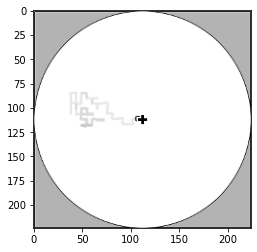

In [32]:
plt.imshow(arr, cmap='gray')
plt.show()

In [60]:
drone_pos_dict={'Drone0': mimic({   'x_val': 14.724202156066895,
                    'y_val': -2.943709135055542,
                    'z_val': -9.155741691589355}),
'Drone1': mimic({   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355}),
'Drone3': mimic({   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355})}


In [61]:
# export
def Penalty4Backtrack(df_gps, x,y, dist=20, penalty=-3, drone_dict=None):
    ''' given gps dataframe x,y on most recent index
        calcuates the distance to previous x,y positions
        returns the reward for every position within dist
    '''
    df_tmp=df_gps.copy()
    if drone_dict is not None:
        idx2ignore=list(itertools.chain(*[list(df_tmp[df_tmp['vehicle_name']==vehicle_name].index[-4:]) 
                       for vehicle_name in drone_dict.keys()]))
    else: idx2ignore= list(df_tmp.index[-4:])
        
    df_tmp['Distance2Drone']=np.sqrt((x-df_tmp['x_position'])**2+ (y-df_tmp['y_position'])**2)
    return len(df_tmp[(df_tmp['Distance2Drone']<dist)&(~df_tmp.index.isin(idx2ignore))]) * penalty


In [62]:
# export
def DroneDistanceReward(d):
    if d>=50:
        return  -math.exp(10-(-d+100)**0.5)/100
    else: 
        return (-math.exp(-d**0.5+9))/100


In [63]:
# reward for distance between drones
if drone_pos_dict is not None:
    for other_drone in drone_pos_dict.keys():
        if other_drone == vehicle_name: continue
        x_pos=(drone_pos_dict[vehicle_name].x_val-drone_pos_dict[other_drone].x_val)
        y_pos=(drone_pos_dict[vehicle_name].y_val-drone_pos_dict[other_drone].y_val)
        z_pos=(drone_pos_dict[vehicle_name].z_val-drone_pos_dict[other_drone].z_val)

        rss=math.sqrt(x_pos*x_pos+y_pos*y_pos+z_pos*z_pos)
        print(DroneDistanceReward(rss))

-81.03083927575385
-81.03083927575385


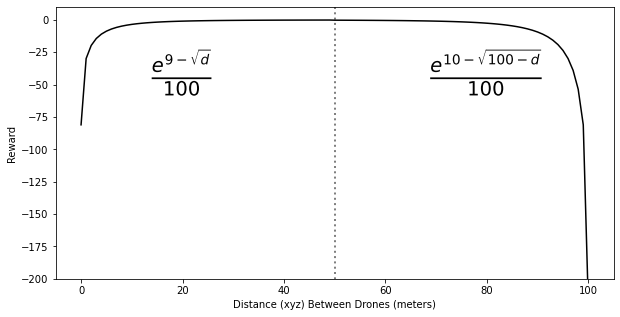

In [77]:
plt.figure(figsize=(10,5))
D=np.arange(0,101,1)
reward=[DroneDistanceReward(d) for d in D]
plt.plot(D, reward, color='k')
plt.vlines(50,10,-200, color='grey',linestyles=':', lw=2)
ax=plt.gca()
draw_outline(ax.text(20, -50 , r'$\frac{e^{9-\sqrt{d}}}{100}$', color='Black', 
                                fontsize=28,  ha='center'),5, foreground='white')

draw_outline(ax.text(80, -50 , r'$\frac{e^{10 - \sqrt{100 - d}}}{100}$', color='Black', 
                                fontsize=28,  ha='center'),5, foreground='white')

#reward=[(-math.exp(-(d)**0.5+10))/100+100 for d in D]
#plt.plot(D, reward)

plt.ylabel('Reward')
plt.xlabel('Distance (xyz) Between Drones (meters)')
plt.ylim(-200,10)
plt.savefig('plots/Drone_Distance-Reward.png', bbox_inches='tight')
plt.show()

In [65]:
# export
def NoFlyZoneReward(d):
    if d<0: return -4000
    else: return max((-math.exp(-d**0.7+10))/60, -4000)

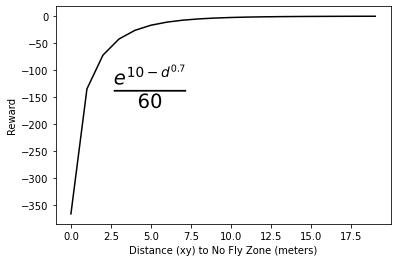

In [76]:
D=np.arange(0,20,1)
reward=[NoFlyZoneReward(d) for d in D]
plt.plot(D, reward, color='k')

ax=plt.gca()
draw_outline(ax.text(5, -150 , r'$\frac{e^{10 - d^{0.7}}}{60}$', color='Black', 
                                fontsize=28,  ha='center'),5, foreground='white')
#plt.grid()
plt.ylabel('Reward')
plt.xlabel('Distance (xy) to No Fly Zone (meters)')
plt.savefig('plots/No_Fly_Zone-Reward.png', bbox_inches='tight')
plt.show()


In [67]:
df_nofly=pd.DataFrame([[37.2, 50.9, 15], [175,60,20]], columns=['x','y','radius']) 

In [68]:
x_crnt=0
y_crnt=9
if len(df_nofly)>0:
    for idx in df_nofly.index:
        x_pos=x_crnt-df_nofly.loc[idx,'x']
        y_pos=y_crnt-df_nofly.loc[idx,'y']
        rss=math.sqrt(x_pos*x_pos+y_pos*y_pos)
        print(NoFlyZoneReward(rss-df_nofly.loc[idx,'radius']))

-0.0005216921368116883
-1.7988002495815841e-13


In [69]:
# export
def HghtReward(z):
    if z>=31:
        return -math.exp(z**0.5)/300
    else: 
        return -1/math.exp(z**0.5-10)/100


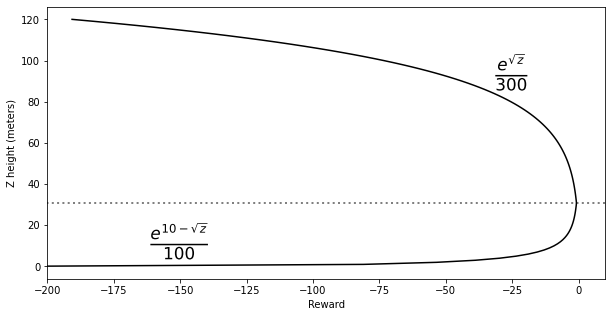

In [74]:
plt.figure(figsize=(10,5))
ax=plt.gca()
Z=np.arange(0,121,1)
reward=[HghtReward(z) for z in Z]
plt.plot(reward, Z, color='k')
plt.hlines(31,10,-200, color='grey',linestyles=':', lw=2)
plt.xlabel('Reward')
plt.ylabel('Z height (meters)')

draw_outline(ax.text(-25,90 , r'$\frac{e^{\sqrt{z}}}{300}$', color='Black', 
                                fontsize=24,  ha='center'),5, foreground='white')

draw_outline(ax.text( -150, 8 , r'$\frac{e^{10 - \sqrt{z}}}{100}$', color='Black', 
                                fontsize=24,  ha='center'),5, foreground='white')

plt.xlim(-200,10)
plt.savefig('plots/Z-Reward.png', bbox_inches='tight')
plt.show()

In [75]:
60/1.5

40.0

In [72]:
# export
def plot_Reward(df_summary, path, filename, show=False):
    fig=plt.figure(figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
    filename = os.path.join(path, f'{filename}.png')
    plt.scatter(df_summary['Episode'], df_summary['Score'], alpha=0.5, label='Episode Score')
    plt.plot(df_summary['Episode'], df_summary['Average Score'], color='orange', label='Running Average')
    plt.ylabel('Reward')
    plt.xlabel('Episodes')
    plt.legend(loc=2)

    #plt.ylim(-1000,10)
    plt.grid()
    
    
    plt.savefig(filename)
    if show: plt.show()
    
    plt.close(fig)
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()



In [76]:
pd.set_option('display.max_rows', 500)

In [79]:
df_summary=pd.read_csv('data/Neighborhood_600s_DDQNAgent_2022-03-23.csv')

In [80]:
#df_summary['Average Score']=[np.mean(df_summary.loc[df_summary.index[idx:-50], 'Score']) for idx in df_summary.index]

In [81]:
df_summary

,Episode,Score,Average Score,Best Score,steps,Model Saved,Epsilon,Dropout,Vehicle Name
0,0,-25879.765418,-25879.765418,-inf,174,False,0.9953,0.001,Drone0
1,1,-29445.846024,-27662.805721,-inf,284,False,0.9843,0.001,Drone0
2,2,-13917.372877,-23080.994773,-inf,336,False,0.9791,0.001,Drone0
3,3,-28397.723362,-24410.176920,-inf,447,False,0.9680,0.001,Drone0
4,4,-17724.028740,-23072.947284,-inf,507,True,0.9620,0.001,Drone0
...,...,...,...,...,...,...,...,...,...
250,250,-4504.949328,-2927.169838,-253.515892,20451,False,0.0999,0.001,Drone0
251,251,-459.907978,-2648.497492,-253.515892,20542,False,0.0999,0.001,Drone0
252,252,-4008.213001,-2757.527149,-253.515892,20590,False,0.0999,0.001,Drone0
253,253,-4275.225836,-2833.176026,-253.515892,20643,False,0.0999,0.001,Drone0


In [82]:
#np.mean(df_summary.loc[df_summary.index[:-50], 'Score'])

In [83]:
print(df_summary.tail().T)

                   250      251      252      253      254
Episode            250      251      252      253      254
Score         -4504.95 -459.908 -4008.21 -4275.23 -607.404
Average Score -2927.17  -2648.5 -2757.53 -2833.18 -2559.43
Best Score    -253.516 -253.516 -253.516 -253.516 -253.516
steps            20451    20542    20590    20643    20735
Model Saved      False    False    False    False    False
Epsilon         0.0999   0.0999   0.0999   0.0999   0.0999
Dropout          0.001    0.001    0.001    0.001    0.001
Vehicle Name    Drone0   Drone0   Drone0   Drone0   Drone0


In [84]:
filename='Neighborhood_DDQNAgent_2022-03-14'
path='plots'

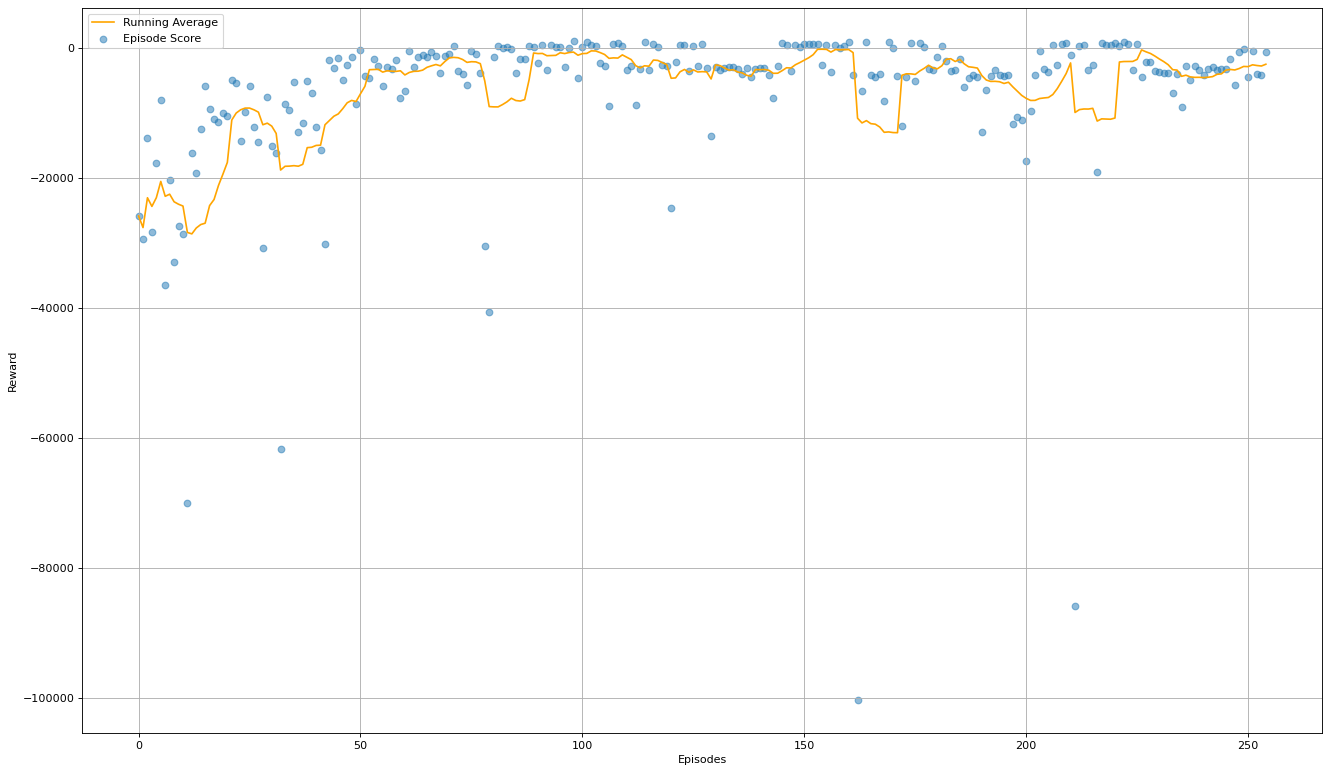

<Figure size 432x288 with 0 Axes>

In [85]:
plot_Reward(df_summary, path, filename, show=True)

In [86]:
df_summary[df_summary['Model Saved']==True]

,Episode,Score,Average Score,Best Score,steps,Model Saved,Epsilon,Dropout,Vehicle Name
4,4,-17724.028740,-23072.947284,-inf,507,True,0.9620,0.001,Drone0
5,5,-8066.190355,-20571.821129,-2.307295e+04,549,True,0.9578,0.001,Drone0
19,19,-10101.269235,-19458.979927,-2.057182e+04,1816,True,0.8311,0.001,Drone0
20,20,-10512.396927,-17644.853636,-1.945898e+04,1921,True,0.8206,0.001,Drone0
21,21,-4912.067244,-11133.245998,-1.764485e+04,1960,True,0.8167,0.001,Drone0
22,22,-5374.559361,-10057.469697,-1.113325e+04,1994,True,0.8133,0.001,Drone0
23,23,-14347.040395,-9558.166980,-1.005747e+04,2098,True,0.8029,0.001,Drone0
24,24,-9906.602065,-9302.870655,-9.558167e+03,2209,True,0.7918,0.001,Drone0
25,25,-5912.972415,-9297.319359,-9.302871e+03,2245,True,0.7882,0.001,Drone0
47,47,-2626.848758,-8488.909333,-9.297319e+03,3978,True,0.6149,0.001,Drone0


In [87]:
# export
def RoadBelowReward(img, rng=50, reward=100, nonlinear=False):
    # input image, 2*rng =center square, 
    # reward for being over the road is concentrated around the center of the image and dissipates near edges
    # OR looks at center of image and gets the percent of pixels that are equal to 1. (road)
    # returns reward or road percent * the reward

    x,y=img.shape
    x=int(x/2)
    y=int(y/2)
    img_cntr=img[x-rng:x+rng,y-rng:y+rng].copy()
    img_cntr=np.ma.masked_where(img_cntr == 1, img_cntr).mask.astype(int)

    try:
        if nonlinear:
            rwd_arr=np.array(list(np.arange(1,rng+1))+list(np.arange(rng,0,-1)))
            rwd_mat=rwd_arr*rwd_arr[np.newaxis].T
            rwd_mat=rwd_mat/(rwd_mat.max()*1000)
            return (img_cntr*rwd_mat*reward).sum()          
        
        else: return (img_cntr.sum()/(rng*2)**2)*reward
    except: return 0

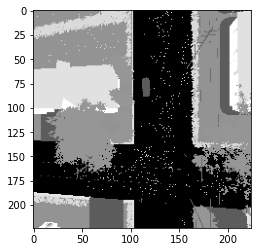

61.0

In [88]:
arr=np.load('data/Bottom_center_Seg_z30.npy')
plt.imshow(arr, cmap='Greys')
plt.show()
RoadBelowReward(arr, rng=50, reward=100)

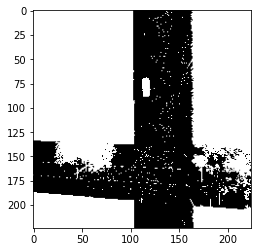

In [96]:
plt.imshow(np.ma.masked_where(arr == 1, arr).mask.astype(int), cmap='Greys')


In [36]:
# export
def initialGPS(x_cntr,y_cntr, sz=(224, 224), df_nofly=None):
    #################################### Plotting #########################################################
    rad=100
    fig, ax = plt.subplots(figsize=(5,5))
    ax=plt.gca(); ax.set_axis_off()
    ax.add_patch(patches.Rectangle((x_cntr-rad,y_cntr-rad+1), width=rad*2-1, height=rad*2-1, ec='k', facecolor='#b3b3b3'))
    ax.add_patch(plt.Circle((x_cntr,y_cntr), rad, ec='k', facecolor='white'))
    plt.xlim(x_cntr-rad,x_cntr+rad); plt.ylim(y_cntr-rad,y_cntr+rad) 

    if df_nofly is not None: # plot the no fly zone
        for idx in df_nofly.index:
            ax.add_patch(plt.Circle((df_nofly.loc[idx,'x'], df_nofly.loc[idx,'y']), df_nofly.loc[idx,'radius'],
                                hatch='xxx',facecolor='grey'))

    plt.plot(x_cntr, y_cntr ,marker='P', color='k', lw=6, ms=16, markeredgecolor='white',linestyle='None',markeredgewidth=2)
    plt.tight_layout()
    fig.canvas.draw()

    # plot to image array
    arr = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    arr = arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    # this padding only works for 224x224 images
    arr=cv2.resize(arr[9:-11, 9:-11], (sz), interpolation=cv2.INTER_CUBIC)
    # close the figure
    plt.close(fig)
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()

    return arr/255

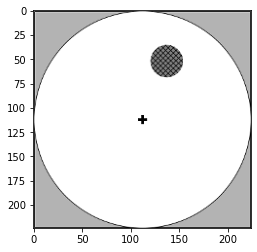

In [37]:
df_nofly=pd.DataFrame([[37.2, 50.9, 15]], columns=['x','y','radius']) #37.2, 50.9, 15]
home=(15, -3, -30)
x_cntr=home[0]
y_cntr=home[1]
sz=(224, 224) 
arr=initialGPS(x_cntr,y_cntr, sz=(224, 224), df_nofly=df_nofly)
plt.imshow(arr, cmap='gray')
plt.show()

In [47]:
# export
def DistanceSensor2Image(x_cntr,y_cntr, distance_dict,scale=5, sz=(224, 224), df_nofly=None):
    front_dist = distance_dict['Front']
    back_dist = distance_dict['Back']
    left_dist = distance_dict['Left']
    right_dist = distance_dict['Right']
    z_ht = distance_dict['Z']
    rad=100
    
    #################################### Plotting #########################################################    
    fig, ax = plt.subplots(figsize=(5,5))
    ax=plt.gca(); ax.set_axis_off()
    ax.add_patch(patches.Rectangle((x_cntr-rad,y_cntr-rad+1), width=rad*2-1, height=rad*2-1, ec='k', facecolor='#b3b3b3'))
    ax.add_patch(plt.Circle((x_cntr,y_cntr), rad, ec='k', facecolor='white'))
    plt.xlim(x_cntr-rad,x_cntr+rad); plt.ylim(y_cntr-rad,y_cntr+rad) 

    if df_nofly is not None: # plot the no fly zone
        for idx in df_nofly.index:
            ax.add_patch(plt.Circle((df_nofly.loc[idx,'x'], df_nofly.loc[idx,'y']), df_nofly.loc[idx,'radius'],
                                hatch='xxx',facecolor='grey'))

    # Front (in image to the right)
    plt.plot([x_cntr,x_cntr+front_dist], [y_cntr,y_cntr] ,lw=6, color=Value2Color(z_ht, vmin=-10, vmax=120, palette='Greys', zerocolor='#e3e3e3'))   
    if front_dist<scale*1.1: plt.plot(x_cntr+front_dist, y_cntr ,marker='x', color='k', lw=6, ms=16,linestyle='None')
    # Back (in image to the left)
    plt.plot([x_cntr,x_cntr-back_dist], [y_cntr,y_cntr] ,lw=6, color=Value2Color(z_ht, vmin=-10, vmax=120, palette='Greys', zerocolor='#e3e3e3'))  
    if back_dist<scale*1.1: plt.plot(x_cntr-back_dist, y_cntr ,marker='x', color='k', lw=6, ms=16,linestyle='None')
    # Left (in image to the top)     
    plt.plot([x_cntr,x_cntr], [y_cntr,y_cntr+left_dist] ,lw=6, color=Value2Color(z_ht, vmin=-10, vmax=120, palette='Greys', zerocolor='#e3e3e3')) 
    if left_dist<scale*1.1: plt.plot(x_cntr, y_cntr+left_dist ,marker='x', color='k', lw=6, ms=16,linestyle='None')
    # Reft (in image to the bottom) 
    plt.plot([x_cntr,x_cntr], [y_cntr,y_cntr-right_dist] ,lw=6, color=Value2Color(z_ht, vmin=-10, vmax=120, palette='Greys', zerocolor='#e3e3e3')) 
    if right_dist<scale*1.1: plt.plot(x_cntr, y_cntr-right_dist ,marker='x', color='k', lw=6, ms=16,linestyle='None')

        # current Location
    plt.plot(x_cntr, y_cntr ,marker='P', color='k', lw=6, ms=16, markeredgecolor='white',linestyle='None',markeredgewidth=2)

    plt.tight_layout()
    fig.canvas.draw()

    # plot to image array
    arr = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    arr = arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    # this padding only works for 224x224 images
    arr=cv2.resize(arr[9:-11, 9:-11], (sz), interpolation=cv2.INTER_CUBIC)

    # close the figure
    plt.close(fig)
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()

    return arr/255

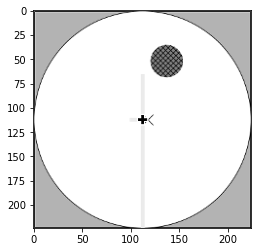

In [48]:
home=(15, -3, -30)
arr=DistanceSensor2Image(x_cntr=home[0],y_cntr=home[1],scale=5, distance_dict={'Front': 5, 'Back': 10, 'Left':40, 'Right':100, 'Z':10}, 
                         sz=(224, 224), df_nofly=pd.DataFrame([[37.2, 50.9, 15]], columns=['x','y','radius']))
plt.imshow(arr, cmap='gray')
plt.show()

In [6]:
z_home=np.random.randint(-50, high=-7, size=1, dtype=int)[0];
z_home

-13

In [20]:
df_home=pd.DataFrame([[15,0],
            [73,0],
           [110,0],
           [0,0],
           [0,120],
           [0,-120]], columns=['x','y'])
df_home['z']=np.random.randint(-60, high=-12, size=len(df_home), dtype=int)
df_home=df_home+np.random.random_sample((len(df_home), 3)) *10-5

[17.96834353291605, -4.670515931479468, -57.89352630231708]

In [12]:
np.random.randint(-50, high=-7, size=1, dtype=int)

array([-46])

In [17]:
np.random.random_sample((len(df_home), 2)) *10-5

array([[ 1.95270573, -4.62632505],
       [-2.34803503, -3.36084533],
       [-4.23370892,  1.86163132],
       [ 0.8705697 , -1.25627798],
       [-0.99968993,  1.82922926],
       [-0.51415017, -4.77441745]])

In [36]:
list(df_home.loc[df_home[df_home.index!=0].sample().index[0], ['x','y']])+[20]

[69.28075028699006, 3.8061147057708915, 20]

In [40]:
df_nofly=pd.DataFrame([], columns=['x','y','radius']) 
df_nofly.loc[len(df_nofly)]=list(df_home.loc[df_home[df_home.index!=0].sample().index[0], ['x','y']])+[20]
df_nofly

,x,y,radius
0,1.832581,-4.621664,20.0


In [41]:
[list(df_home.loc[df_home[df_home.index!=0].sample().index[0], ['x','y']])+[20],list(df_home.loc[df_home[df_home.index!=0].sample().index[0], ['x','y']])+[20]]

[[114.551837826603, -4.915479828463117, 20],
 [69.28075028699006, 3.8061147057708915, 20]]

In [9]:
df_home=pd.DataFrame([[15,0], [73,0], [110,0], [0,0],[0,120],[0,-120]], columns=['x','y'])
df_home['z']=np.random.randint(-60, high=-12, size=len(df_home), dtype=int)
df_home.loc[df_home[df_home['z'].between(-45,-30)].index,'z']=-75
df_home.loc[df_home[df_home['z'].between(-30.1,-18)].index,'z']=-10
df_home=df_home+np.random.random_sample((len(df_home), 3)) *10-5
df_home.loc[df_home[df_home['z']>-3].index,'z']=-5

In [10]:
df_home

,x,y,z
0,11.560186,-3.440055,-14.419164
1,76.661761,1.011150,-72.919274
2,105.205845,4.699099,-42.675574
3,-2.876609,-3.181750,-13.165955
4,-1.957578,120.247564,-53.680550
5,-2.087709,-118.881471,-78.605061


In [11]:
import seaborn as sns

<AxesSubplot:xlabel='z', ylabel='Count'>

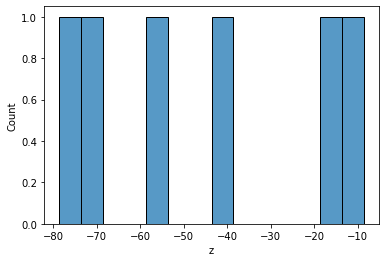

In [13]:
sns.histplot(df_home['z'], binwidth=5)

In [1]:
!python notebook2script.py Utilities.ipynb

Converted Utilities.ipynb to nb_files/nb_Utilities.py


In [2]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Friday April 01, 2022 at 15:38
